# Обучение с учителем: качество модели

# Описание проекта
Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.
«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. Нужно разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

### Цель проекта 
Разработать и внедрить систему персонализированных предложений для постоянных клиентов интернет-магазина "В один клик" с целью удержания активности постоянных клиентов и увеличения их покупательской активности.
### План проекта 

[**Шаг 0. Импорт библиотек, методы**](#step_00)

[**Шаг 1. Загрузка данных**](#step_01)

[**Шаг 2. Предобработка данных**](#step_02)

[**Шаг 3. Исследовательский анализ**](#step_03)

[**Шаг 4. Объединение таблиц**](#step_04)

[**Шаг 5. Корреляционный анализ**](#step_05)

[**Шаг 6. Использование пайплайнов**](#step_06)

[**Шаг 7. Анализ важности признаков**](#step_07)

[**Шаг 8. Сегментация покупателей**](#step_08)

[**Шаг 9. Вывод**](#step_09)



# Шаг 0. Импорт библиотек, методы


<a id="step_00"></a>

In [1]:
''' 
Добрый день! Если в проекте возникнет конфликт между нашими библиотеками, раскоментируй, пожалуйста, этот код
'''
# ! conda install -y numpy'>=1.22 <=1.26'
# ! pip install shap 
# ! pip install -U scikit-learn

' \nДобрый день! Если в проекте возникнет конфликт между нашими библиотеками, раскоментируй, пожалуйста, этот код\n'

In [2]:
#импорт нужных библиотек
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import shapiro
import shap

from sklearn.compose import ColumnTransformer
from sklearn.impute import  SimpleImputer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier


/Users/admin/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Методы

In [3]:
def duplicates(columns, df):
    for column in columns:
        unique_values = df[column].unique()
        print(f'Уникальные значения в колонке {column}: {unique_values}')

In [4]:
def create_histogram(data, column, bins=50):
    """
    Input:
    - data: Датафрейм, содержащий данные.
    - column: Наименование столбца, для которого нужно построить гистограмму.
    - title: Заголовок гистограммы.
    - bins: Количество бинов для гистограммы (по умолчанию 50)

    Output:
    - None

    Description:
    Функция создает гистограмму для указанного столбца в датафрейме при помощи библиотеки seaborn. 
    Результат выводится на экран.
    """
    plt.figure(figsize=(12, 6))
    sns.set()
    sns.histplot(data=data, x=column, kde=True, bins=bins)
    plt.title(f'{column} - Плотность распределения', fontsize=18)
    plt.xlabel(column, fontsize=14)
    plt.ylabel('Частота', fontsize=14)
    plt.show()

In [5]:
def create_barplot(data, column, rotation=45):
    """
    Input:
    - data (DataFrame): Исходный DataFrame с данными.
    - column (str): Название колонки, для которой нужно построить диаграмму.
    - title (str): Заголовок для столбчатой диаграммы.
    
    Output:
    None

    Description:
    Функция создает столбчатую диаграмму на основе данных из указанной колонки.
    """
    plt.figure(figsize=(10, 6))
    plt.xticks(rotation=rotation)
    new_data = data[column].value_counts()
    df_new_data = new_data.reset_index()
    df_new_data.columns = [column, 'count']

    sns.barplot(x=column, y='count', data = df_new_data)
    plt.title(f'{column}.Плотность распределения')
    plt.xlabel(f'{column}')
    plt.ylabel(f'количество {column}')

In [6]:
def cat_num_col(df):
    """
    Input:
    - df(DataDrame): Исходный DataFrame с данными
    Output:
    - num_col_names(list) - список столбцов с количественными признаками
    - cat_col_names(list) - список столбцов с категориальными признаками

    Description:
    Функция возвращает списки с названиями столбцов категориальных и количественных признаков. id из списка удаляется

    """
    num_col_names = list(df.select_dtypes(include=['int64', 'float64']).columns)
    cat_col_names = list(df.select_dtypes(include=['object']).columns)
    num_col_names.remove('id')
    return num_col_names, cat_col_names

In [7]:
def shapiro_test(data, column):
    """
    Функция выполняет тест Шапиро-Уилка на нормальность данных в указанном столбце.

    Параметры:
        - data: pandas DataFrame, входные данные
        - column: str, название столбца, для которого выполняется тест

    Вывод:
        - печать результата теста Шапиро-Уилка, включая статистику теста и p-значение
        - вывод сообщения о том, является ли распределение данных нормальным
    """ 
    statistic, p_value = shapiro(data[column])

    # Печать результата теста
    alpha = 0.05  # Уровень значимости
    print(f'Результат теста Шапиро-Уилка для столбца {column}:')
    print(f'Статистика теста: {statistic}')
    print(f'p-значение: {p_value}')
    if p_value > alpha:
        print('Распределение данных является нормальным.')
    else:
        print('Распределение данных не является нормальным.')

In [8]:
def scatter_dataframe(df):
    num_cols = df.select_dtypes(exclude='object').columns.to_list()
    parameters = []
    for i in num_cols:
        for j in num_cols:
            if (i != j) and (i != 'id') and (j != 'id'):
                if ((i, j) not in parameters) and ((j, i) not in parameters):
                    df.plot(x=i, y=j, kind='scatter')
                    k = i, j
                    parameters.append(k)
    None
    

# Шаг 1. Загрузка данных


<a id="step_01"></a>

In [9]:
try:
    df_market_file = pd.read_csv('https://code.s3.yandex.net/datasets/market_file.csv')
    df_market_money = pd.read_csv('https://code.s3.yandex.net/datasets/market_money.csv')
    df_market_time = pd.read_csv('https://code.s3.yandex.net/datasets/market_time.csv', decimal=',')
    df_money = pd.read_csv('https://code.s3.yandex.net/datasets/money.csv', sep = ';', decimal=',')
except Exception:
    print('Упc, кажется такого файла нет')

### **Изучим данные df_market_file**

In [10]:
df_market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [11]:
df_market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


Данный датафрейм содержит информацию о 1300 записях с 13 столбцами. Типы данных включают в себя int64, float64 и object. Столбцы представляют собой различные аспекты
В датафрейме есть следующие столбцы:
* **Покупательская активность** — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».

* **Тип сервиса** — уровень сервиса, например «премиум» и «стандарт».

* **Разрешить сообщать** — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.

* **Маркет_актив_6_мес** — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.

* **Маркет_актив_тек_мес** — количество маркетинговых коммуникаций в текущем месяце.

* **Длительность** — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.

* **Акционные_покупки** — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.

* **Популярная_категория** — самая популярная категория товаров у покупателя за последние 6 месяцев.

* **Средний_просмотр_категорий_за_визит** — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.

* **Неоплаченные_продукты_штук_квартал** — общее число неоплаченных товаров в корзине за последние 3 месяца.

* **Ошибка_сервиса** — число сбоев, которые коснулись покупателя во время посещения сайта.

* **Страниц_за_визит** — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

### **Изучим данные df_market_money**

In [12]:
df_market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [13]:
df_market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


Данный датафрейм состоит из 3900 записей с 3 столбцами
В датафейме есть следующие столбцы

* **id** — номер покупателя в корпоративной базе данных.

* **Период** — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.

* **Выручка** — сумма выручки за период.

### **Изучим данные df_market_time** 

In [14]:
df_market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [15]:
df_market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


Данный датафрейм состоит из 2600 записей с 3 столбцами
* **id** — номер покупателя в корпоративной базе данных.

* **Период** — название периода, во время которого зафиксировано общее время.

* **минут** — значение времени, проведённого на сайте, в минутах.

### **Изучим данные df_money** 

In [16]:
df_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


In [17]:
df_money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


### Вывод 
Проверили первичный просмотр всех предоставленных данных

# Шаг 2. Предобработка данных

<a id="step_02"></a>

**Изучим дубликаты**

In [18]:
data_frames = [df_market_file, df_market_money, df_market_time, df_money]

for data in data_frames:
    data_name = [key for key, value in locals().items() if value is data][0]
    print(f'Количество дубликатов в датафрейме {data_name}: {data.duplicated().sum()}')
    if data.duplicated().sum() > 0:
        data.drop_duplicates(inplace=True)
        print(f'Количество дубликатов в датафрейме {data_name}: {data.duplicated().sum()}')

Количество дубликатов в датафрейме df_market_file: 0
Количество дубликатов в датафрейме df_market_money: 0
Количество дубликатов в датафрейме df_market_time: 0
Количество дубликатов в датафрейме df_money: 0


Проверим неявные дубликаты. Если они есть - заменим 

In [19]:
print('df_market_file')
columns = ['Покупательская активность', 'Тип сервиса', 'Популярная_категория', ]
duplicates(columns, df_market_file)
print()
print('df_market_money')
columns = ['Период']
duplicates(columns, df_market_money)
print()
print('df_market_time')
duplicates(columns, df_market_time)


df_market_file
Уникальные значения в колонке Покупательская активность: ['Снизилась' 'Прежний уровень']
Уникальные значения в колонке Тип сервиса: ['премиум' 'стандартт' 'стандарт']
Уникальные значения в колонке Популярная_категория: ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']

df_market_money
Уникальные значения в колонке Период: ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']

df_market_time
Уникальные значения в колонке Период: ['текущий_месяц' 'предыдцщий_месяц']


In [20]:
df_market_file['Тип сервиса'] = df_market_file['Тип сервиса'].replace('стандартт','стандарт')

In [21]:
df_market_time['Период'] = df_market_time['Период'].replace('предыдцщий_месяц','предыдущий_месяц')

**Изучим пропуски**

In [22]:
for data in data_frames:
    data_name = [key for key, value in locals().items() if value is data][0]
    print(f'прошущенные значения в {data_name}:\n{data.isnull().sum().sort_values()}')
    print()

прошущенные значения в df_market_file:
id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

прошущенные значения в df_market_money:
id         0
Период     0
Выручка    0
dtype: int64

прошущенные значения в df_market_time:
id        0
Период    0
минут     0
dtype: int64

прошущенные значения в df_money:
id         0
Прибыль    0
dtype: int64



### Вывод 
1) Пропусков и дубликатов в датафрйемах не обнаружено
2) Неявные дубликаты, которые возникли из-за опечаток, устранили 

# Шаг 3. Исследовательский анализ данных

<a id="step_03"></a>

### Проведем исследовательский анализ данных df_market_file

In [23]:
df_market_file.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1300.0,215997.500000,375.421985,215348.0,215672.75,215997.50,216322.25,216647.00
Маркет_актив_6_мес,1300.0,4.253769,1.014814,0.9,3.70,4.20,4.90,6.60
Маркет_актив_тек_мес,1300.0,4.011538,0.696868,3.0,4.00,4.00,4.00,5.00
Длительность,1300.0,601.898462,249.856289,110.0,405.50,606.00,806.00,1079.00
Акционные_покупки,1300.0,0.319808,0.249843,0.0,0.17,0.24,0.30,0.99
Средний_просмотр_категорий_за_визит,1300.0,3.270000,1.355350,1.0,2.00,3.00,4.00,6.00
Неоплаченные_продукты_штук_квартал,1300.0,2.840000,1.971451,0.0,1.00,3.00,4.00,10.00
Ошибка_сервиса,1300.0,4.185385,1.955298,0.0,3.00,4.00,6.00,9.00
Страниц_за_визит,1300.0,8.176923,3.978126,1.0,5.00,8.00,11.00,20.00


Выведем графики

In [24]:
num_col_names_market, cat_col_names_market = cat_num_col(df_market_file)

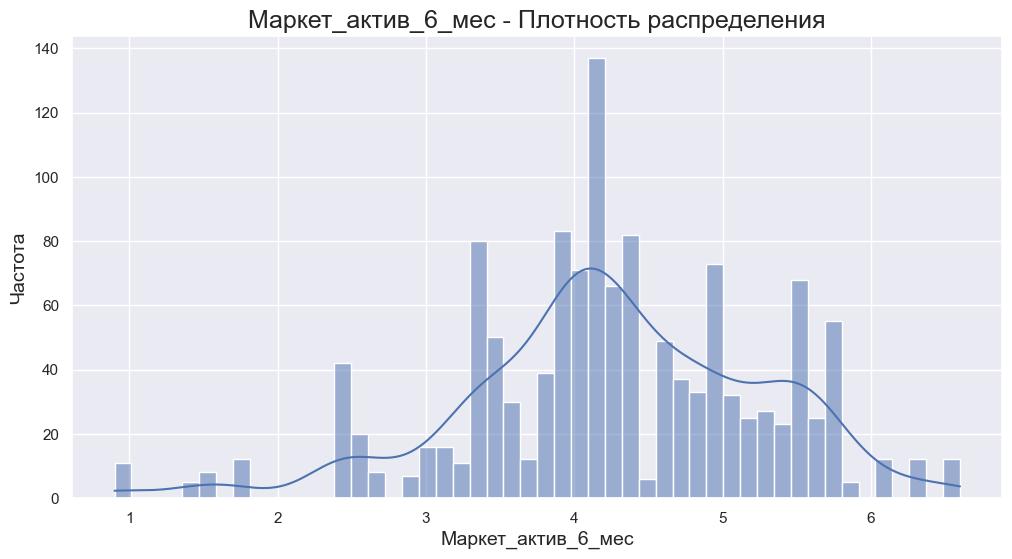

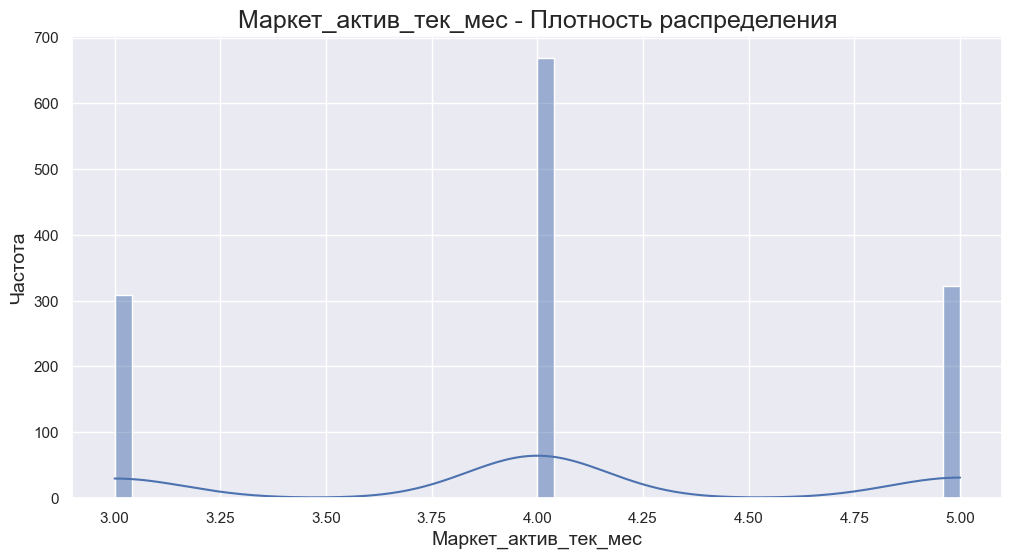

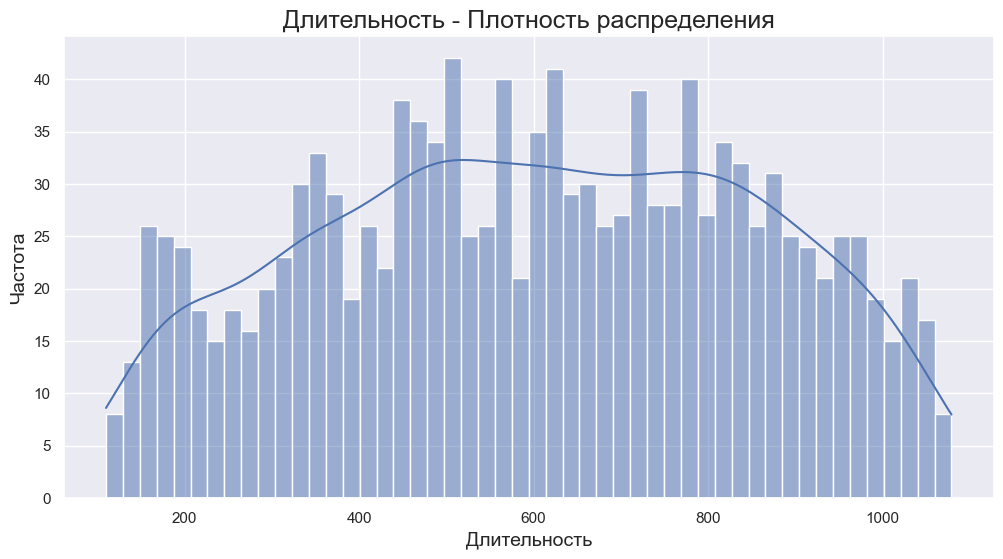

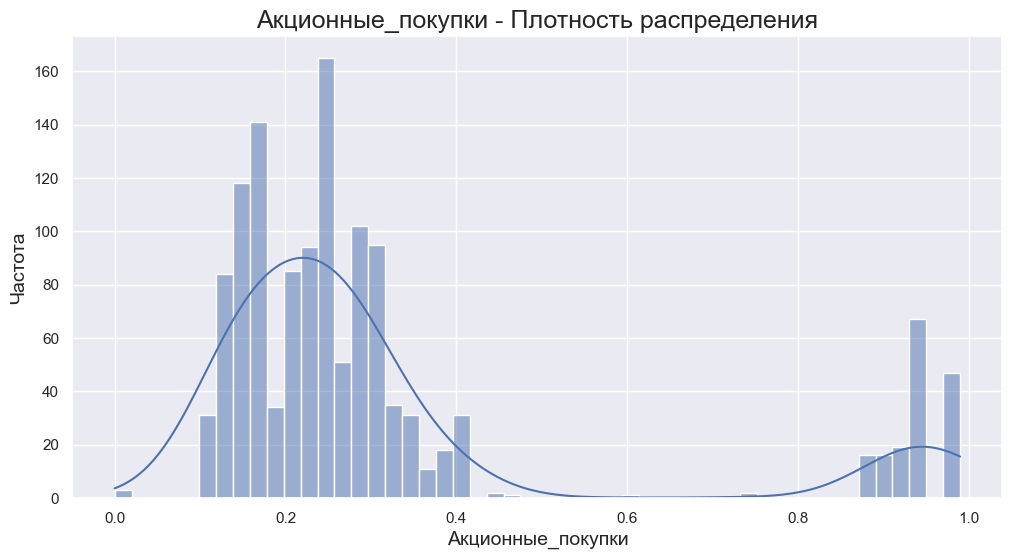

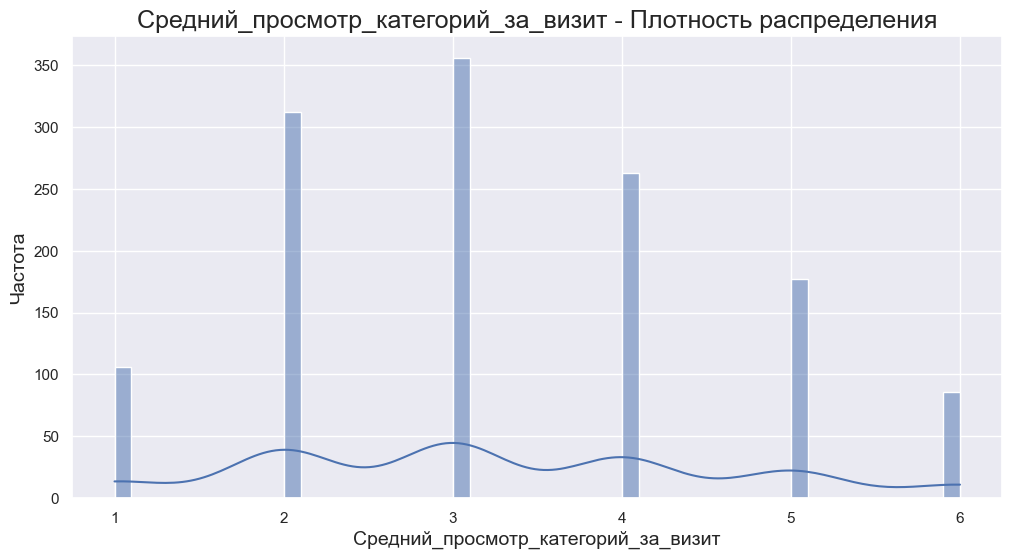

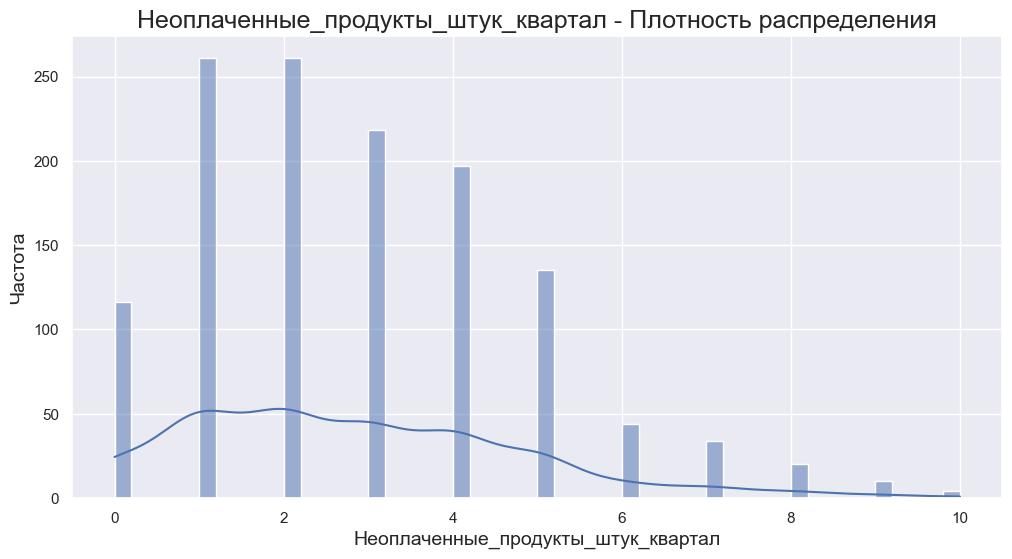

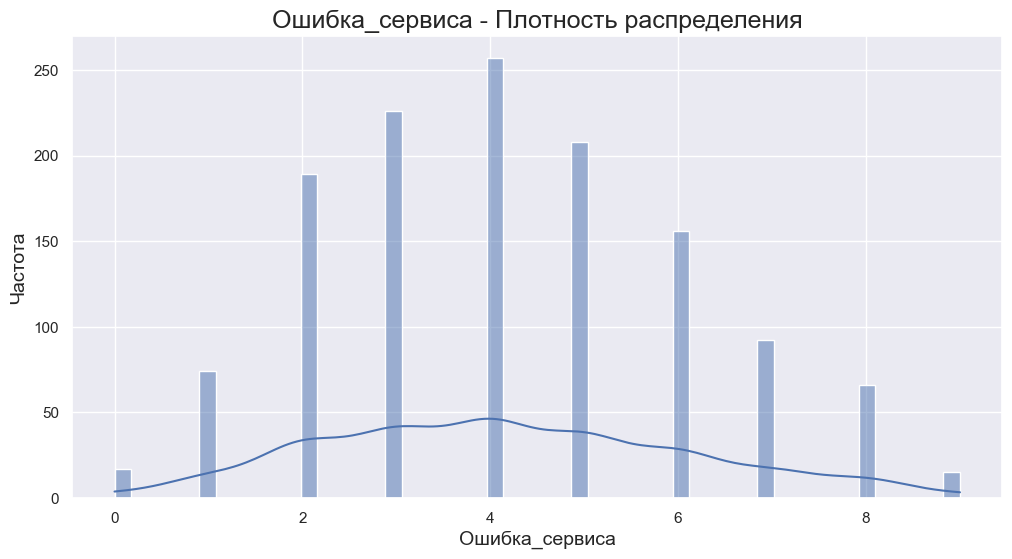

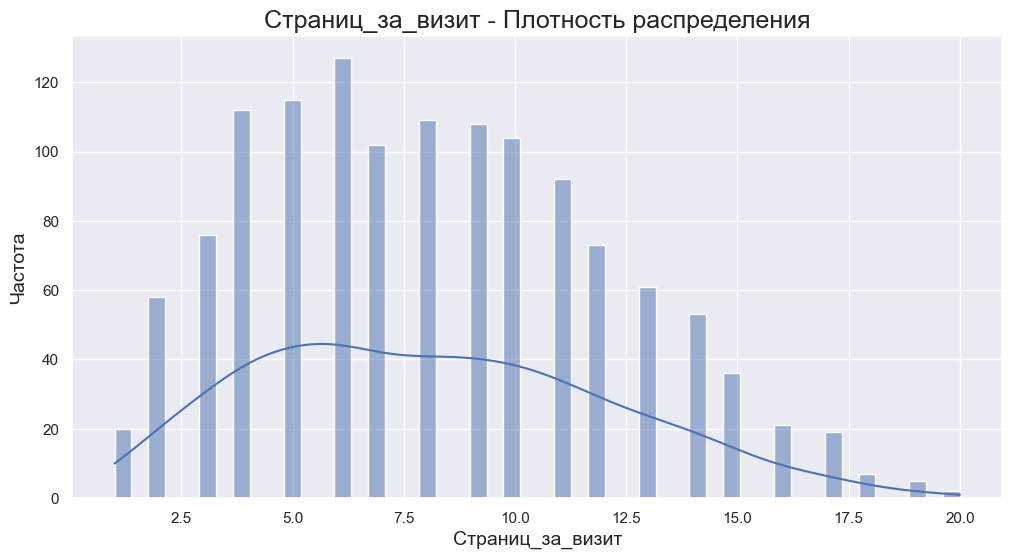

In [25]:
for num_name in num_col_names_market:
    create_histogram(df_market_file, num_name, bins=50)

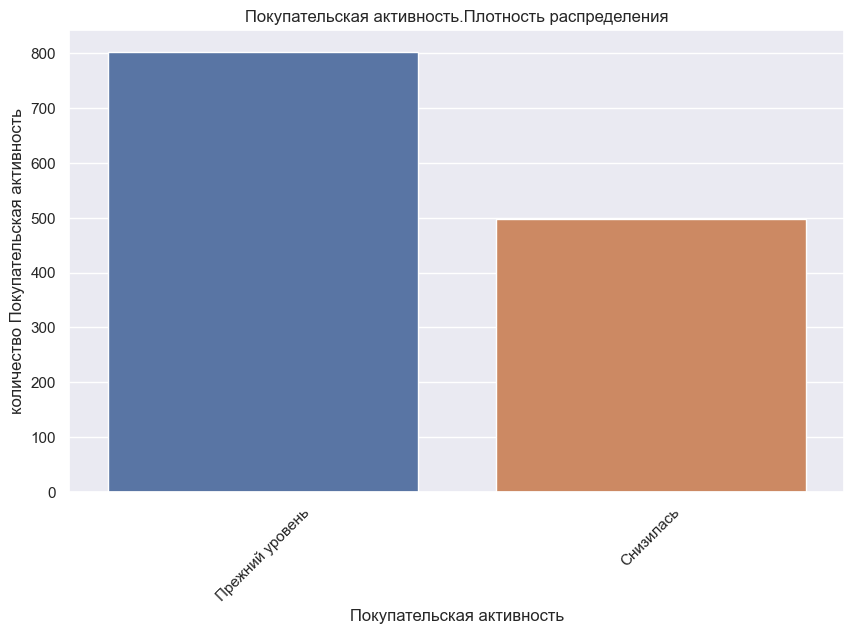

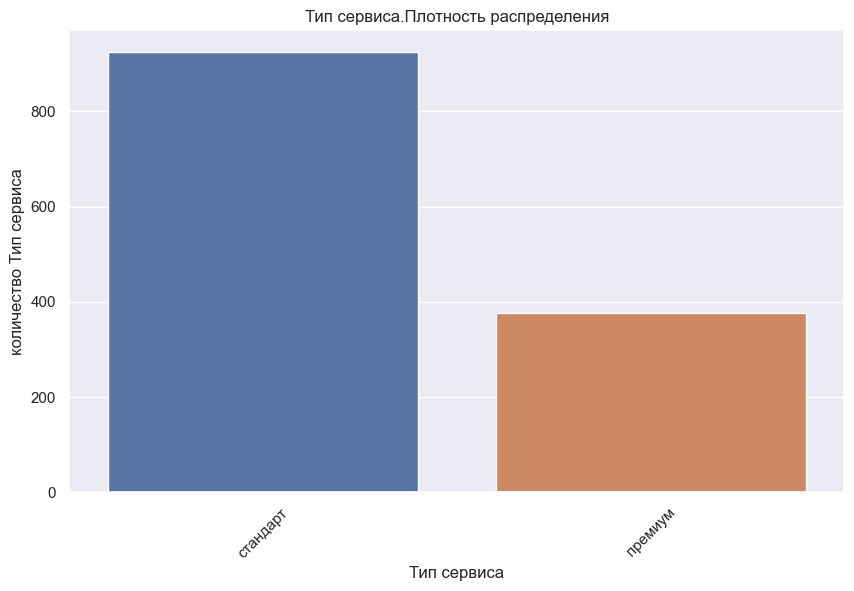

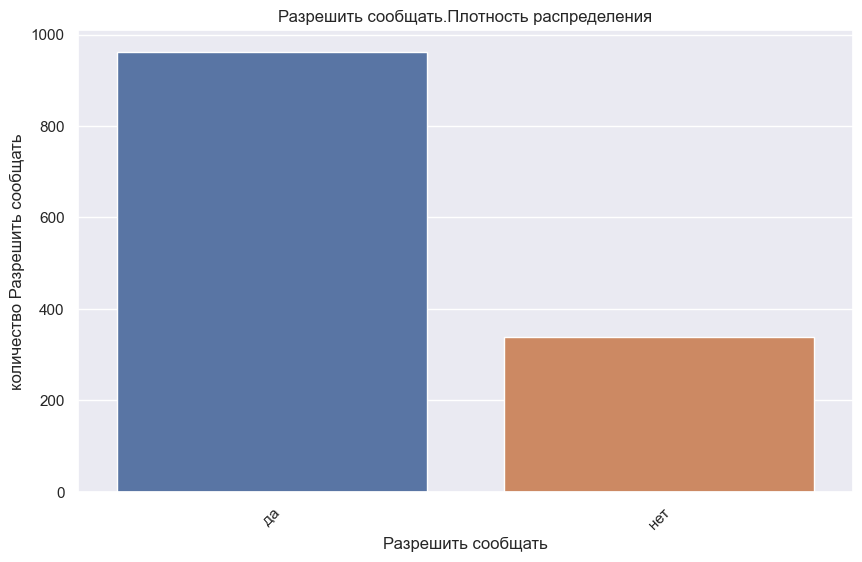

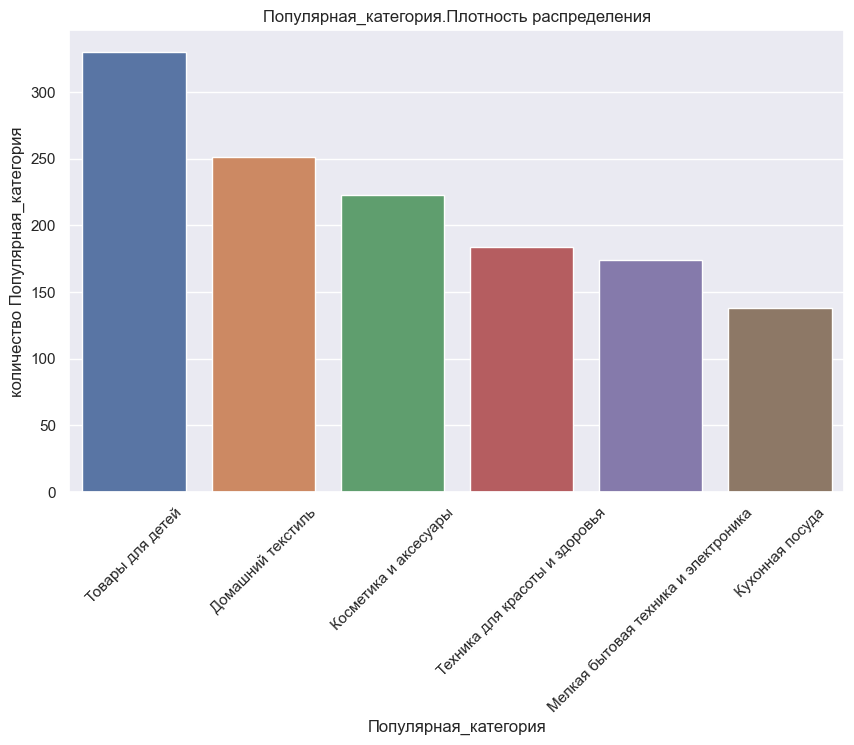

In [26]:
for cat_name in cat_col_names_market:
    create_barplot(df_market_file, cat_name)

 ### Проведем исследовательский анализ данных df_market_money

In [27]:
df_market_money.describe().T

,count,mean,std,min,25%,50%,75%,max
id,3900.0,215997.500000,375.325686,215348.0,215672.75,215997.5,216322.25,216647.0
Выручка,3900.0,5025.696051,1777.704104,0.0,4590.15,4957.5,5363.00,106862.2


In [28]:
num_col_names_market_money, cat_col_names_market_money = cat_num_col(df_market_money)

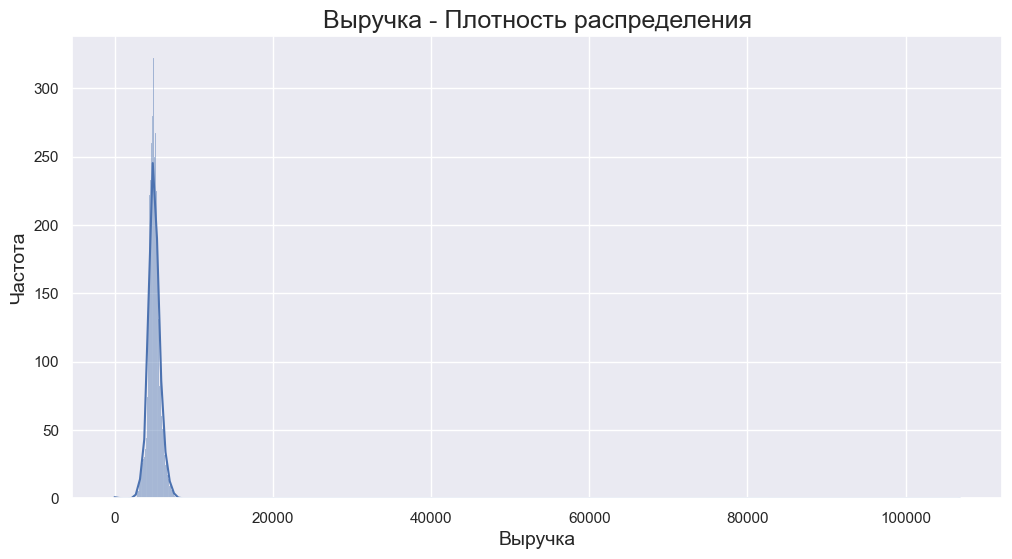

In [29]:
for num_name in num_col_names_market_money:
    create_histogram(df_market_money, num_name, bins=1000)

Здесь имеется явный выброс. Избавимся от него 

In [30]:
df_market_money = df_market_money[(df_market_money['Выручка'] <= 20000) & 
                                  (df_market_money['Выручка'] >= 3000) ]


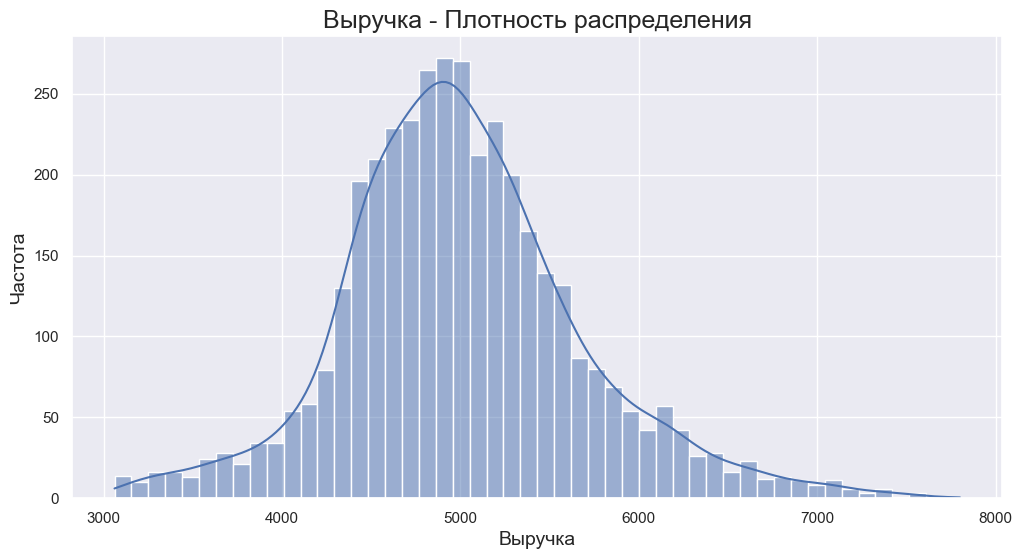

In [31]:
for num_name in num_col_names_market_money:
    create_histogram(df_market_money, num_name, bins=50)

 ### Проведем исследовательский анализ данных df_market_time

In [32]:
df_market_time.describe().T

,count,mean,std,min,25%,50%,75%,max
id,2600.0,215997.500000,375.349754,215348.0,215672.75,215997.5,216322.25,216647.0
минут,2600.0,13.336154,4.080198,4.0,10.00,13.0,16.00,23.0


In [33]:
num_col_names_market_time, cat_col_names_market_time = cat_num_col(df_market_time)

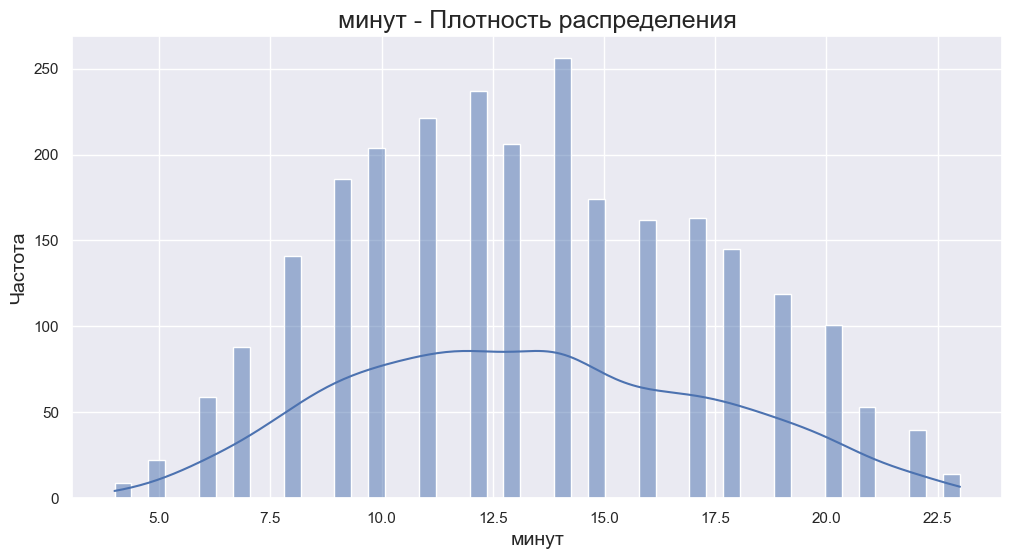

In [34]:
for num_name in num_col_names_market_time:
    create_histogram(df_market_time, num_name, bins=50)

### Вывод 
Удалили выбросы при необходимости 

# Этап 4. Объединение таблиц

<a id="step_04"></a>

Нам нужно отобрать покупателей с покупательской активностью не менее трех месяцев. Для этого нужно, чтобы данные о прибыли были за все 3 месяца. Поэтому план действий такой 
1) Сделать сводную таблицу по выручке за все 3 месяца из датафрейма df_market_money
2) Сделать сводную таблицу по выручке за все 2 месяца из датафрейма df_market_time. Это необходимо, чтобы при дальнейшем объединеннии у нас не образовалось строк с одинаковыми данными, кроме колонок периода на сайте в разные месяцы 
3) Объединить сводные таблицы с df_market_file
4) Удалить тех покупателей, у которых есть пропуски в одной из колонок прибыли за 3 месяца 

In [35]:
df_pivot_money = df_market_money.pivot(index='id', columns='Период', values='Выручка')
df_pivot_money.head()

Период,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
id,,,
215348,NaN,NaN,3293.1
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5


In [36]:
df_pivot_time = df_market_time.pivot(index='id', columns='Период', values='минут')

In [37]:
df_pivot_time.head()

Период,предыдущий_месяц,текущий_месяц
id,,
215348,13,14
215349,12,10
215350,8,13
215351,11,13
215352,8,11


In [38]:
df_pivot_time = df_pivot_time.rename(columns={
    'текущий_месяц': 'минут_за_текущий_месяц',
    'предыдущий_месяц': 'минут_за_предыдущий_месяц'
})

In [39]:
df_pivot_money = df_pivot_money.rename(columns={
    'текущий_месяц': 'выручка_за_текущий_месяц',
    'предыдущий_месяц': 'выручка_за_предыдущий_месяц',
    'препредыдущий_месяц': 'выручка_за_препредыдущий_месяц'
})


In [40]:
merged_df = df_market_file.merge(df_pivot_money, on='id', how='left')

In [41]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 0 to 1299
Data columns (total 16 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [42]:
merged_df = merged_df.merge(df_pivot_time, on='id', how='left')

In [43]:
merged_df.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,выручка_за_предыдущий_месяц,выручка_за_препредыдущий_месяц,выручка_за_текущий_месяц,минут_за_предыдущий_месяц,минут_за_текущий_месяц
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,NaN,NaN,3293.1,13,14
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11


In [44]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 0 to 1299
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [45]:
merged_df.duplicated().sum()

0

In [46]:
merged_df.isna().sum()

id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
выручка_за_предыдущий_месяц            7
выручка_за_препредыдущий_месяц         3
выручка_за_текущий_месяц               3
минут_за_предыдущий_месяц              0
минут_за_текущий_месяц                 0
dtype: int64

In [47]:
merged_df = merged_df.dropna()
merged_df.isna().sum()

id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
выручка_за_предыдущий_месяц            0
выручка_за_препредыдущий_месяц         0
выручка_за_текущий_месяц               0
минут_за_предыдущий_месяц              0
минут_за_текущий_месяц                 0
dtype: int64

# Этап 5. Корреляционный анализ

<a id="step_05"></a>

Перед выполнением корреляционного анализа сделаем Шапиро тест на проверку нормальности распределения. Если хотя бы у одного признака не будет нормального распределения - в качестве корреляционного анализа будем использовать тест Спирмена 

In [48]:
num_col, cat_col = cat_num_col(merged_df)
for col_name in num_col:
    shapiro_test(merged_df, col_name)
    print()

Результат теста Шапиро-Уилка для столбца Маркет_актив_6_мес:
Статистика теста: 0.9780727028846741
p-значение: 4.267343043599242e-13
Распределение данных не является нормальным.

Результат теста Шапиро-Уилка для столбца Маркет_актив_тек_мес:
Статистика теста: 0.8057685494422913
p-значение: 9.358731205706592e-37
Распределение данных не является нормальным.

Результат теста Шапиро-Уилка для столбца Длительность:
Статистика теста: 0.9723674058914185
p-значение: 5.341152596160387e-15
Распределение данных не является нормальным.

Результат теста Шапиро-Уилка для столбца Акционные_покупки:
Статистика теста: 0.6572721004486084
p-значение: 5.605193857299268e-45
Распределение данных не является нормальным.

Результат теста Шапиро-Уилка для столбца Средний_просмотр_категорий_за_визит:
Статистика теста: 0.9305405616760254
p-значение: 5.24692095661257e-24
Распределение данных не является нормальным.

Результат теста Шапиро-Уилка для столбца Неоплаченные_продукты_штук_квартал:
Статистика теста: 0.93

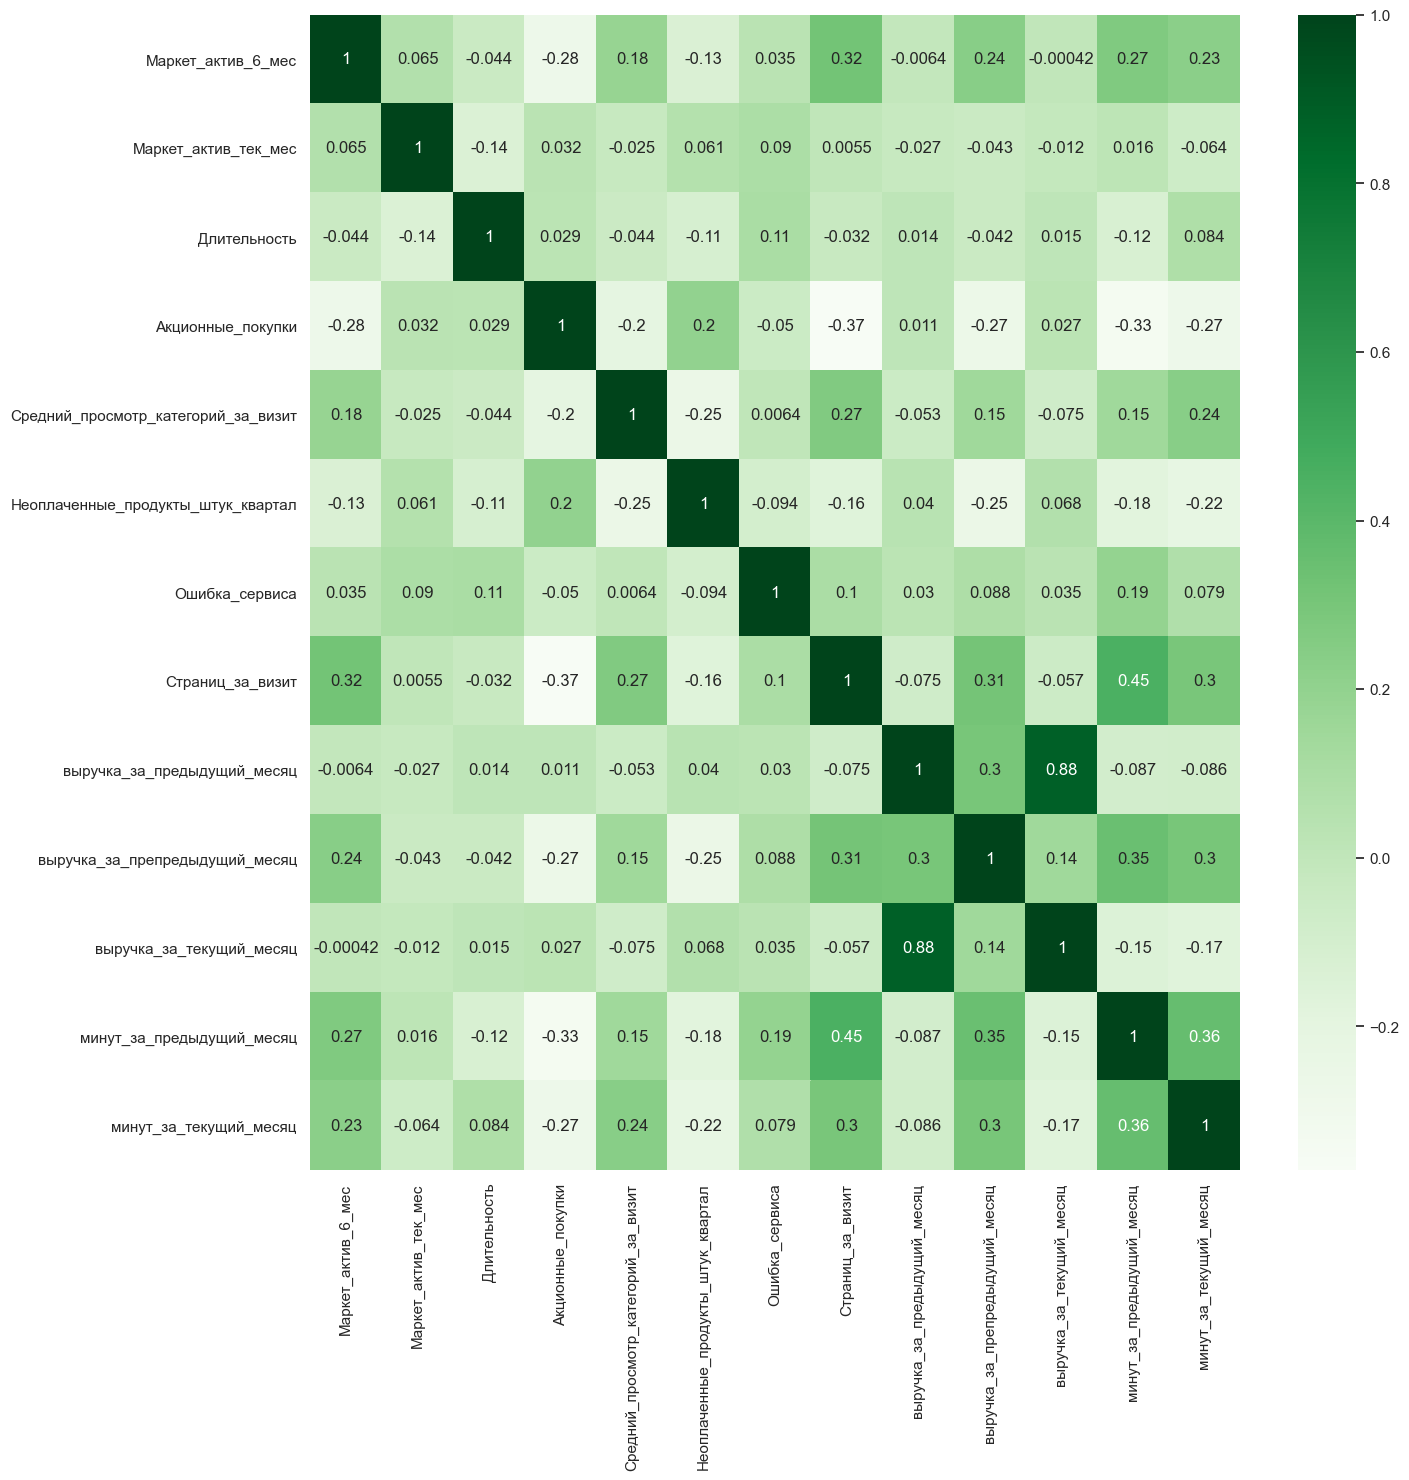

In [49]:

corr = merged_df[num_col].corr(method = 'spearman')
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr, annot = True, cmap="Greens")
None

# Этап 6: Пайплайн 

<a id="step_06"></a>

Напишем пайплан. Следующий план действий

1) Разделение данных на обучающую и тестовую выборки, с установкой размера тестовой выборки (25%) и заданием стратификации для сохранения баланса классов.
2) Подготовка преобразований для категориальных признаков (OneHotEncoder) и порядковых признаков (OrdinalEncoder) с использованием операций замещения отсутствующих значений (SimpleImputer).
3) Создание трансформера данных, который объединяет преобразования признаков, включая масштабирование числовых признаков с использованием StandardScaler.
4) Создание пайплайна, включающего предварительную обработку данных и модель (DecisionTreeClassifier).
5) Определение сетки параметров для различных моделей, включая DecisionTreeClassifier, LogisticRegression, SVC и KNeighborsClassifier.
6) Использование RandomizedSearchCV для поиска лучших параметров моделей с целью максимизации метрики roc_auc на тренировочной выборке.
7) Обучение лучшей модели на обучающих данных и оценка ее производительности на тестовых данных с выводом лучших параметров, метрики лучшей модели на тренировочной выборке и метрики ROC-AUC на тестовой выборке.

In [50]:

merged_df['Покупательская активность'] = merged_df['Покупательская активность'].apply(lambda x: 0 if x == 'Снизилась' else (1 if x == 'Прежний уровень' else x))


In [51]:
RANDOM_STATE = 42
TEST_SIZE = 0.25
X_train, X_test, y_train, y_test = train_test_split(
    merged_df.drop(['Покупательская активность', 'id'], axis=1),
    merged_df['Покупательская активность'],
    random_state=RANDOM_STATE,
    test_size=TEST_SIZE,
    stratify = merged_df['Покупательская активность']
)
matrix =   merged_df.drop(['Покупательская активность', 'id'], axis=1)
ohe_col = ['Популярная_категория']
ord_col = ['Тип сервиса', 'Разрешить сообщать']

In [52]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='error', sparse=False)
        )
    ]
)

ord_pipe = Pipeline([
    (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
    (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['стандарт', 'премиум'], 
                    ['нет', 'да'],
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
    ), 
    (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
]
)

data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_col),
        ('ord', ord_pipe, ord_col),
        ('num', StandardScaler(), num_col)
    ], 
    remainder='passthrough'
) 

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

Например, для модели DecisionTreeClassifier определяем гиперпараметры max_depth, min_samples_split, и min_samples_leaf, которые контролируют глубину дерева, минимальное количество образцов для разделения внутреннего узла и минимальное количество образцов в листе соответственно. Эти параметры позволяют настраивать уровень детализации и предотвращать переобучение модели.

Для модели LogisticRegression определяем гиперпараметр C, который регулирует силу регуляризации, а также был выбран предпроцессор preprocessor__num, представляющий набор различных методов нормализации данных для тщательного сравнения и оптимизации модели.

Для модели SVC определяем гиперпараметры, таких как C, kernel, gamma и degree, которые влияют на тонкую настройку модели опорных векторов в многомерном пространстве. Эти параметры позволяют модели гибко определять разделяющие гиперплоскости, что важно для точности классификации.

Для модели KNeighborsClassifier определяем гиперпараметр n_neighbors, который определяет количество соседей, учитываемых при классификации.

В качестве метрики выбираем ROC-AUC (Receiver Operating Characteristic - Area Under the Curve) - это метрика, которая позволяет оценить качество бинарной классификации модели. Она представляет собой площадь под кривой ROC и измеряет способность модели разделять классы путем сравнения вероятностей. Чем выше значение ROC-AUC, тем лучше модель различает между положительным и отрицательным классами.

In [53]:
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': [3, 4, 5],
        'models__min_samples_split': range(1, 10),
        'models__min_samples_leaf': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }, 
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')],
        'models__C': [0.1, 1, 10], 
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }, 
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__C': [0.1, 1, 10],
        'models__kernel': ['rbf', 'sigmoid', 'linear', 'poly'], 
        'models__gamma': [0.1, 1, 10],
        'models__degree': [2, 3, 4],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': [3, 5, 7],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    }
]

random_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE)

random_search.fit(X_train, y_train)
print('Лучшая модель и ее параметры:\n\n', random_search.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', random_search.best_score_)

pred = random_search.predict(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, pred)}')

warnings.filterwarnings('ignore')

/Users/admin/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/admin/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/admin/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/admin/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for t

Лучшая модель и ее параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['Популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
               

### Вывод
На основании предоставленной информации, лучшая модель, полученная в результате обучения, является SVC (метод опорных векторов) с определенными параметрами:

* C (параметр регуляризации) равен 0.1
* degree (степень для ядра полинома) составляет 2
* gamma (коэффициент для ядра) равен 10
* ядро (kernel) установлено как линейное
* probability установлено как True
* random_state установлен на 42
* Метрика лучшей модели на тренировочной выборке составляет 0.8973, что указывает на высокую точность модели на обучающих данных. 
* Метрика ROC-AUC на тестовой выборке составляет 0.8468, что говорит о хорошей способности модели классифицировать тестовые данные.

# Этап 7. Оценка важности признаков

<a id="step_07"></a>

Для оценки важности признаков нужно выполнить следующие действия 
1) Применить предварительную обработку данных к обучающей выборке X_train с помощью метода fit_transform пайплайна pipe_final.
2) Создать объект explainer с использованием бестселлера best_estimator_ из случайного поиска и получить модель с помощью метода named_steps['models']. Затем применить explainer к обработанной обучающей выборке X_train.
3) Применить предварительную обработку данных к тестовой выборке X_test с помощью метода transform пайплайна pipe_final.
Получить имена признаков с помощью get_feature_names_out из трансформера предварительной обработки и создать DataFrame X_test с этими именами.
4) Вычислить значения SHAP для X_test с помощью ранее созданного explainer.
5) Построить столбчатую диаграмму важности признаков с использованием shap.plots.bar и значениями SHAP, рассчитанными на шаге 5.

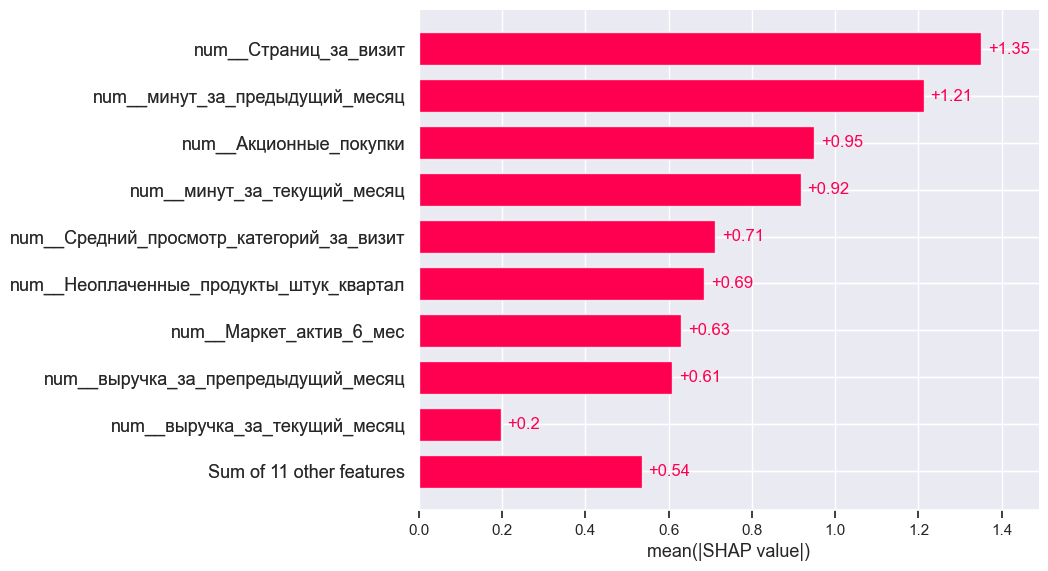

In [54]:
X_train = pipe_final.named_steps['preprocessor'].fit_transform(X_train)
explainer = shap.Explainer(random_search.best_estimator_.named_steps['models'], X_train)

X_test = pipe_final.named_steps['preprocessor'].transform(X_test)

feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()
X_test = pd.DataFrame(X_test, columns =feature_names)
shap_values = explainer(X_test)

shap.plots.bar(shap_values)




In [55]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1290 entries, 1 to 1299
Data columns (total 16 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Тип сервиса                          1290 non-null   object 
 1   Разрешить сообщать                   1290 non-null   object 
 2   Маркет_актив_6_мес                   1290 non-null   float64
 3   Маркет_актив_тек_мес                 1290 non-null   int64  
 4   Длительность                         1290 non-null   int64  
 5   Акционные_покупки                    1290 non-null   float64
 6   Популярная_категория                 1290 non-null   object 
 7   Средний_просмотр_категорий_за_визит  1290 non-null   int64  
 8   Неоплаченные_продукты_штук_квартал   1290 non-null   int64  
 9   Ошибка_сервиса                       1290 non-null   int64  
 10  Страниц_за_визит                     1290 non-null   int64  
 11  выручка_за_предыдущий_месяц   

### Вывод 
Наиболее важные признаки - количество страниц за визит и проведенное время на сайте, акционные покупки, средний просмотр страниц за визит, количество маркетинговых коммуникаций в текущем месяце, неоплаченые покупки. А вот тип сервиса, разрешение рассылки и сколько дней прошло с момента регистрации покупателя на сайте мало значимы. 

На основе наиболее важных признаков модели, можно рассмотреть следующие маркетинговые стратегии для удержания покупателей:

1) Персонализированные рекомендации
2) Улучшение акционных предложений
3) Оптимизация маркетинговых коммуникаций
4)Работа с неоплаченными покупками

# Шаг 8. Сегментация покупателей

<a id="step_08"></a>

Для сегментации покупателей сделаем следующие действия:
1) Произведем фильтрацию данных. В датафрейме df_money оставим только тех, кто есть в merged_df
2) Сделаем предсказание вероятностей с помощью обученной модели random_search и добавление результатов в датафрейм df_segmentation
3) Сделаем построение scatter plot для анализа вероятности снижения и прибыльности
4) После выполним расчет матрицы корреляции и построение тепловой карты корреляции
5) Сделаем присвоение категорий в зависимости 

In [56]:
df_money= df_money[df_money['id'].isin(merged_df['id'])]
proba = random_search.predict_proba(matrix)
df_segmentation = df_money.copy()
df_segmentation['вероятность_снижения'] = proba[:, 0]
df_segmentation.head()

,id,Прибыль,вероятность_снижения
1,215349,4.16,0.936296
2,215350,3.13,0.345143
3,215351,4.87,0.862654
4,215352,4.21,0.966206
5,215353,3.95,0.618488


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<Figure size 1000x600 with 0 Axes>

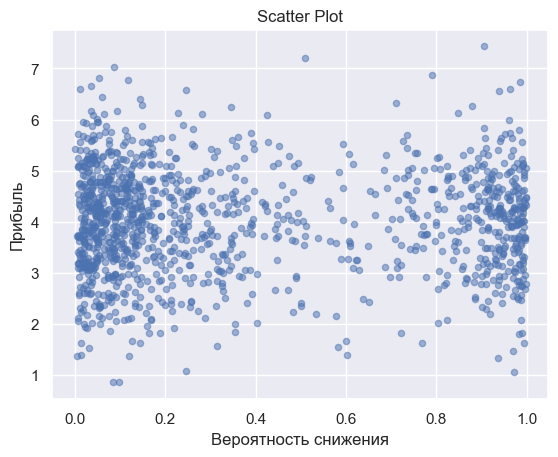

In [57]:
plt.figure(figsize=(10, 6))
df_segmentation.plot(x='вероятность_снижения', y='Прибыль', kind='scatter', alpha=0.5)
plt.title('Scatter Plot')
plt.xlabel('Вероятность снижения')
plt.ylabel('Прибыль')
plt.show()

In [58]:
shapiro_test(df_segmentation, 'вероятность_снижения')
print()
shapiro_test(df_segmentation, 'Прибыль')

Результат теста Шапиро-Уилка для столбца вероятность_снижения:
Статистика теста: 0.8075658679008484
p-значение: 1.2567942349229973e-36
Распределение данных не является нормальным.

Результат теста Шапиро-Уилка для столбца Прибыль:
Статистика теста: 0.9984753131866455
p-значение: 0.31466591358184814
Распределение данных является нормальным.


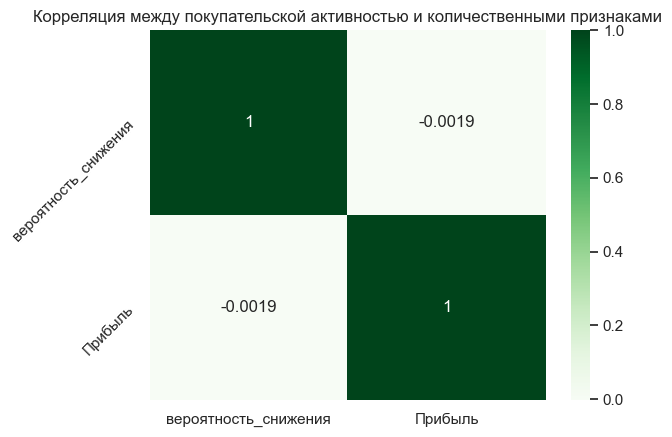

In [59]:
correlation_matrix = df_segmentation[['вероятность_снижения', 'Прибыль']].corr(method='spearman')
sns.heatmap(correlation_matrix, annot=True, cmap='Greens')
plt.yticks(rotation=45)
plt.title(f'Корреляция между покупательской активностью и количественными признаками')
plt.show()


По анализу корреляции и scatter plot можно сделать вывод, что между прибылью от покупателя и вероятностью снижения покупательской активности нет зависимости. 
Поэтому выберем покупателей, у которых высокая прибыль и высокая вероятность снижения покупательской активности и для них подберем стратегии. 

In [60]:
df_segmentation.describe()

,id,Прибыль,вероятность_снижения
count,1290.000000,1290.000000,1290.000000
mean,216000.325581,3.998977,0.376836
std,373.782053,1.010638,0.362463
min,215349.000000,0.860000,0.000018
25%,215678.250000,3.300000,0.073793
50%,216000.500000,4.050000,0.199191
75%,216323.750000,4.670000,0.793444
max,216647.000000,7.430000,0.997873


In [61]:
df_segmentation['категория'] = 'остальные' 
condition = (df_segmentation['Прибыль'] > 4) & (df_segmentation['вероятность_снижения'] > 0.7)
df_segmentation.loc[condition, 'категория'] = 'категория 1'
df_segmentation = df_segmentation[df_segmentation['категория'] != 'остальные']
df_reserch = df_segmentation.merge(merged_df, on='id', how='inner')
df_reserch.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201 entries, 0 to 200
Data columns (total 21 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   201 non-null    int64  
 1   Прибыль                              201 non-null    float64
 2   вероятность_снижения                 201 non-null    float64
 3   категория                            201 non-null    object 
 4   Покупательская активность            201 non-null    int64  
 5   Тип сервиса                          201 non-null    object 
 6   Разрешить сообщать                   201 non-null    object 
 7   Маркет_актив_6_мес                   201 non-null    float64
 8   Маркет_актив_тек_мес                 201 non-null    int64  
 9   Длительность                         201 non-null    int64  
 10  Акционные_покупки                    201 non-null    float64
 11  Популярная_категория            

In [62]:
df_reserch.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201 entries, 0 to 200
Data columns (total 21 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   201 non-null    int64  
 1   Прибыль                              201 non-null    float64
 2   вероятность_снижения                 201 non-null    float64
 3   категория                            201 non-null    object 
 4   Покупательская активность            201 non-null    int64  
 5   Тип сервиса                          201 non-null    object 
 6   Разрешить сообщать                   201 non-null    object 
 7   Маркет_актив_6_мес                   201 non-null    float64
 8   Маркет_актив_тек_мес                 201 non-null    int64  
 9   Длительность                         201 non-null    int64  
 10  Акционные_покупки                    201 non-null    float64
 11  Популярная_категория            

In [63]:
cat_reserch = ['Популярная_категория', 'Разрешить сообщать']
num_reserch = ['Страниц_за_визит', 'минут_за_предыдущий_месяц', 'минут_за_текущий_месяц', 'Акционные_покупки', 
               'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал']

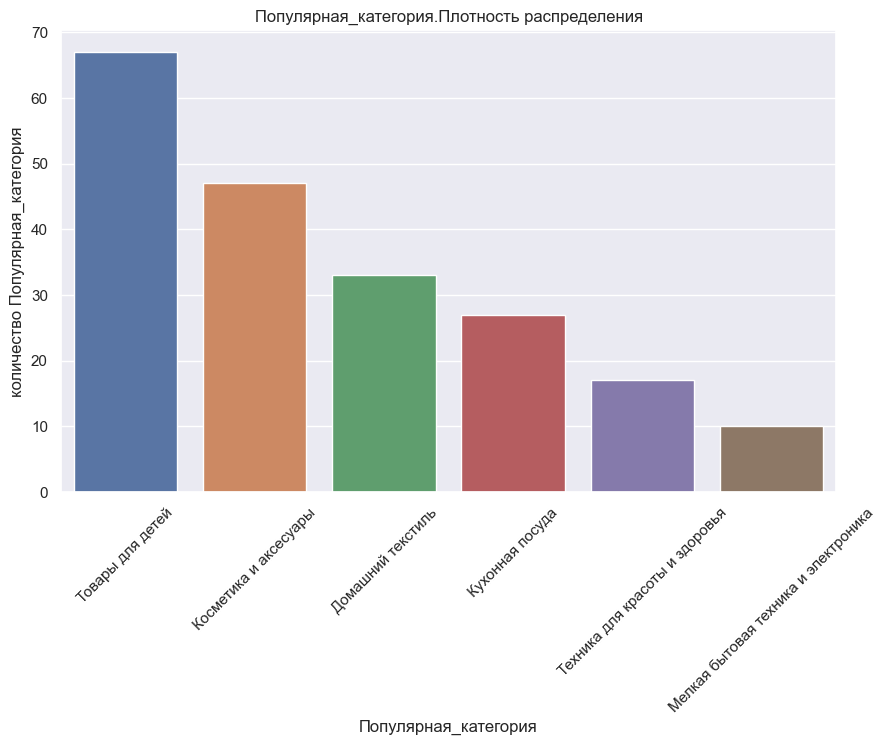

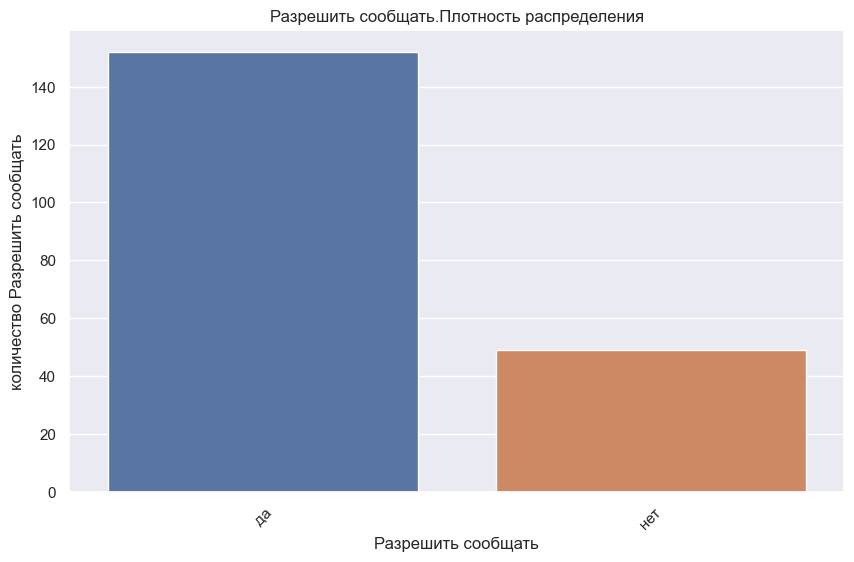

In [64]:
for cat in cat_reserch:
    create_barplot(df_reserch, cat)

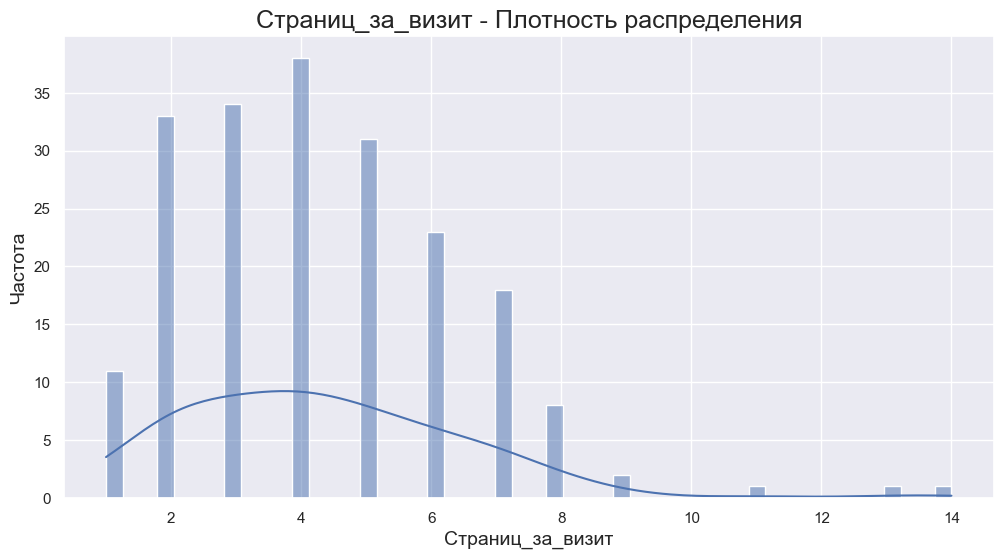

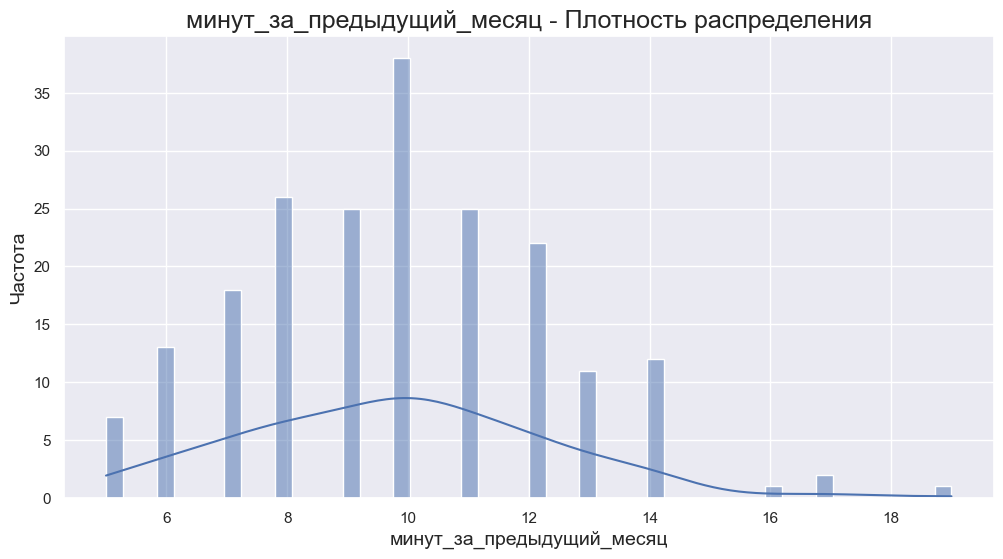

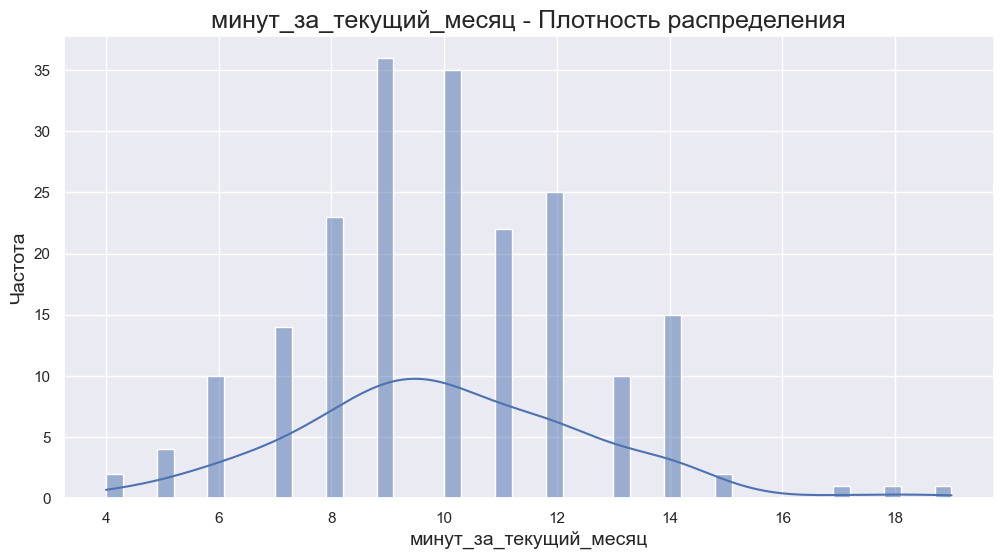

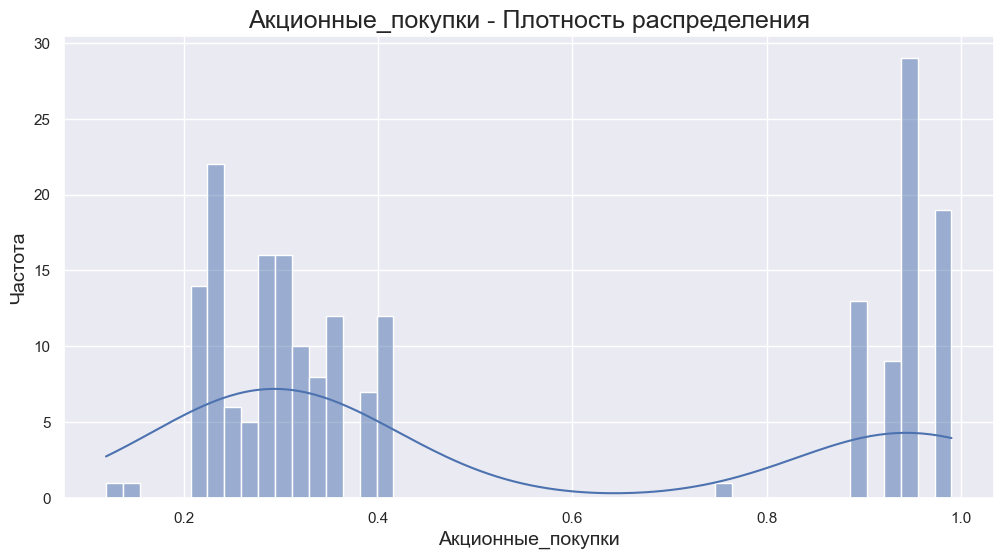

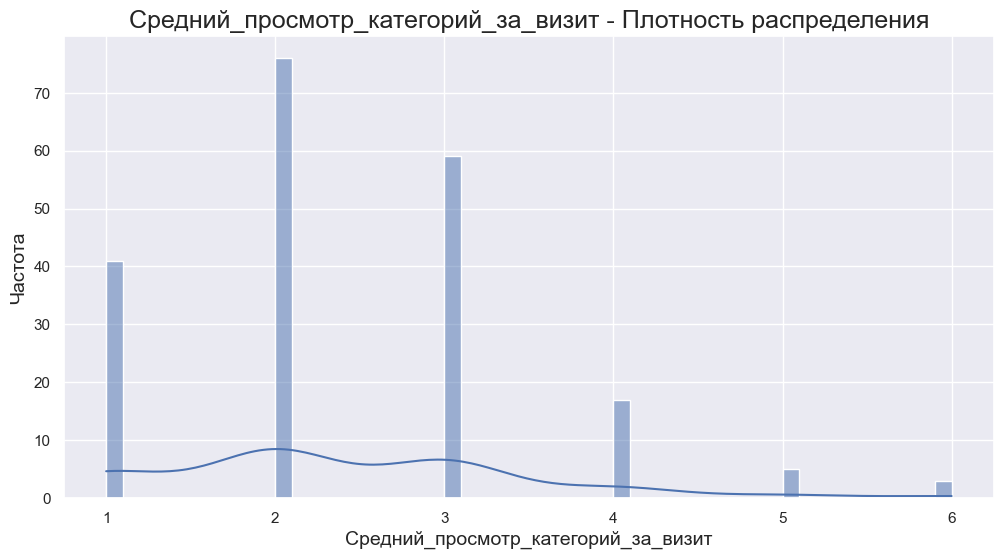

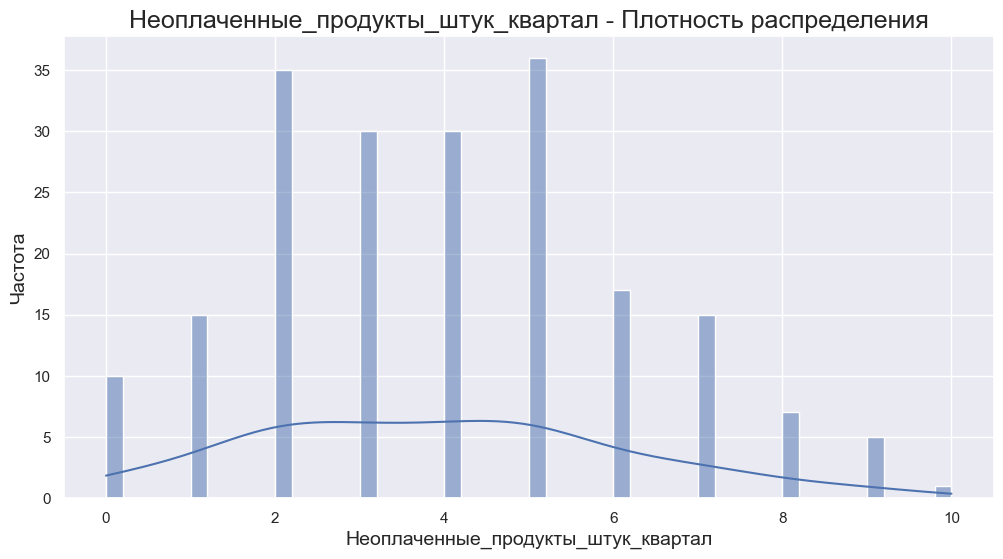

In [65]:
for num in num_reserch:
    create_histogram(df_reserch, num)

### Вывод 
* В качестве целевой аудитории, на которых можно было бы улучшать покупательскую активность - выбрали покупателей с высокой прибылью(от 0.4) и высокой вероятностью снижения активности(выше 70%)
* Таким образом мы видим, что у наших отобранных покупателей самая популярная категория - товары для детей, видно, что акционные покупки пользуются спросом, а у большинства покупателей разрешена рассылка. Из этого можно сделать персональные акции на популярную категорию у каждого покупателя. Либо сезонные акции на детские товары и косметику. 
* Также можно ввести на сайт модель, которая бы анализировала посещение пользователя на сайте и их клики. После чего присылать рассылку с подборкой товаров из популярных категорий
* Можно разработать стратегию для неоплаченных покупок. Например, напоминание через рассылку о том, что стоит оплатить покупки. Или с письмом для обратной связи,если возникли проблемы при оплате. 



# Вывод

Задача: Разработать и внедрить систему персонализированных предложений для постоянных клиентов интернет-магазина "В один клик" с целью удержания активности постоянных клиентов и увеличения их покупательской активности.

В исходных данных было 4 файла: 
* market_file.csv. Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
* market_money.csv. Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
* market_time.csv. Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
* money.csv. Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

В предобработке данных были удалены неявные дубликаты в названиях периодов, а также удалены выбросы. 
Для поиска лучшей модели выбрали KNeighborsClassifier()DecisionTreeClassifier(), LogisticRegression() и  SVC() с гиперпараметрами. Лучшей моделью стала SVC(C=0.1, degree=2, gamma=10, kernel='linear',probability=True, random_state=42). Метрика лучшей модели на тренировочной выборке: 0.8973337035665804
Метрика ROC-AUC на тестовой выборке: 0.8467886178861789

По анализу важности признаков и выбранных покупателей можно сделать следующие стратегии:
1) Можно сделать персональные акции на популярную категорию у каждого покупателя. Либо сезонные акции на детские товары и косметику. 
2) Предложение ввести на сайт модель, которая бы анализировала посещение пользователя на сайте и их клики. После чего присылать рассылку с подборкой товаров из популярных категорий
3) Разработать стратегию для неоплаченных покупок. Например, напоминание через рассылку о том, что стоит оплатить покупки. Или с письмом для обратной связи,если возникли проблемы при оплате. 